## Notes


* Combine depth against time with chlor against time in a single chart
* Third chart idea: Ascent versus Descent scatter plot comparing depth values in relation to y = x
* Overview images to Hunter (MODIS)
  * At different resolutions


### Lat / Lon / Site table


```
Site                    Lat               Lon
------------------      ---               ---
Oregon Offshore        44.37415        -124.95648
Oregon Slope Base      44.52897        -125.38966 
Axial Base             45.83049        -129.75326
```   

### Baseline MODIS 


- We *can* produce Oregon Slope Base MODIS surface chlorophyll values for two months in summer 2019
- Open question: Other locations, same time range (Oregon Offshore, Axial Base particularly)



### Extended MODIS


- June-September time frame, ~13 observations separated by 8 day intervals
- MODIS pixels are <.5 degrees latitude (56km). 
  - Double check; and this seems low in comparison with MODIS-native (500m Rob thinks)
- Can recover chlorophyll values for arbitrary lat/lon locations
- Can do blocks, e.g. 3 x 3 or 11 x 11 pixels centered on a lat/lon location 
- Can probably extend time window

# Introduction


This notebook reviews `yodapy` specific to chlorophyll data and as a guide to OOI data access. 
It stays focused on the Regional Cabled Array (RCA) but should apply as well to other OOI segments. 

In [1]:
# Run this; standard boilerplate
#

import sys
import os
import timeit
from datetime import timedelta, datetime
from random import randint as ri

from matplotlib import pyplot as plt

import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from ftplib import FTP
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import utm
# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

# Local application/library specific imports
from golive_library import GoliveLibrary as g

# Configuring yodapy


The next cells use Python to install and configure yodapy. 


- Before starting establish an account at the [OOI website](https://ooinet.oceanobservatories.org/#). 
  - Generate credentials, do not put them in a GitHub repo but 
keep them somewhere safe. Follow through these cells by un-commenting, running, and re-commenting so that 
you do not re-run them down the road when they are not necessary. 

In [3]:
# Ensure that yodapy is installed directly from github using
# !pip install git+https://github.com/cormorack/yodapy.git

In [4]:
# Un-comment and run this line for one of these two reasons:
#   1. test whether yodapy is installed (if not: Uncomment and run the pip install above)
#   2. prepare to set up your credentials to use the OOI if you haven't done this yet

# from yodapy.utils.creds import set_credentials_file

In [5]:
# Run the next line to create authentication credentials for the OOI data system. Do this
# by ***carefully**** substituting actual credentials in the username and token strings


# set_credentials_file(data_source='ooi', username='OOIAPI-XXXXXXXXXXXXXX', token='XXXXXXXXXXXX')

# Once it runs: Comment it out again and obscure your credentials as Xs.
#   (Don't run it again as it will break the authentication.)

# You can verify this worked by examining the .credentials file in ~/.yodapy: Credentials should match. Notice that 
#   this (slightly hidden) directory is directly connected to your home directory; whereas this IPython notebook 
#   is presumably in a distinct directory; so there should be no chance of a GitHub push sending your 
#   credentials to GitHub. 

### Relocate this comment 


At a low level parquet breaks data in column-wise storage, many small files. Notice this is column-format, not 
row format as we are accustomed to in CSV files. When you read this into dask... a pandas data frame reads the 
entire file... but dask works on lazy eval so dask access to a parquet data ensemble (many of these small chunked 
files) is very efficient as lazy eval. 


Dask reads this data into a dask data frame (which we can consider virtualized / lazy); and a dask data frame is 
analogous to a pandas data frame with that virtualization. 


Athena gives an analogous end-result; it is an AWS service running Apache Hive under the hood. 
You are charged for every query, beware. The access protocol is a SQL query. 

# Create an ooi instance

The ooi instance will enable you to connect to data resources and get datasets. 

In [5]:
# run this DEFINITELY!
from yodapy.datasources import OOI
ooi = OOI()

# `ooi.search()` examples

This use case is asking first "what resources are available?", i.e. sites served by the Regional Cabled Array. 
Then we begin narrowing the search down by adding more keywords (`site`, `node`, `instrument`) to arrive at single
instruments. In subsequent cells we can use these single-instrument results as a basis for ordering a dataset 
with a given time range. 


> **Detail: The green *data availability* chart may fail to render in some cases; and re-running the cell might help.**


The first example models a broad search. We then look at the ooi attributes 'sites' and 'instruments'


```
ooi.search(region='endurance')
ooi.search(region='cabled')

# Attribute 'sites' gives broad results as a table of arrays, sites, descriptions, lat/lon
ooi.sites        

# Narrow result: Conforms to the 'region' filter given above
ooi.instruments

```

The second example narrows the search by stipulating `site`, `node` and `instrument` keywords. 
We look at the `.instruments` attribute to get a table of "hits", one instrument per column.
We run the `.data_availability()` method to get a time series view. Notice that the prior result of instrument columns is transposed to rows in this graphic.

```
ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')
ooi.instruments
ooi.data_availability()
```

In [8]:
# run this to see fluorometers available at Oregon Offshore
# 
#   filters endurance + oregon offshore + fluorometer turn up 7 hits...
#     2 are Oregon Offshore Surface Mooring: 3 wavelength... of future interest in expanding the MODIS connection
#     2 are Oregon Offshore deep profiler CDOM fluorometer
#     2 are Oregon Offshore deep profiler 2 wavelength...    of future interest also (not sure if this is on the RCA)
#     1 is Oregon Offshore shallow profiler 3 wavelength     *** Current interest: RCA MODIS connect ***
#
# ooi.search(region='endurance', site='oregon offshore', instrument='fluorometer')
# ooi.instruments
# ooi.data_availability()

,RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record
0,Cabled Axial Seamount (Cabled Array)
1,Axial Base Shallow Profiler Mooring
2,Shallow Profiler (SF03A)
3,3-Wavelength Fluorometer
4,streamed
5,flort_d_data_record


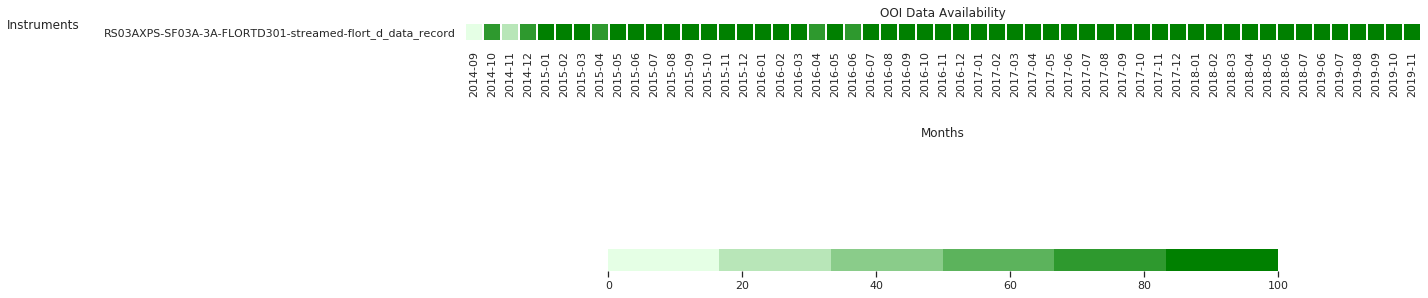

In [43]:
# This ooi.search() call: 
# 
# ooi.search(region='cabled', instrument='fluorometer') 
# 
# produces 12 hits. Here is the breakdown; where results suggest site and node search keywords. 
#  Note that Deep Profiler sites have degeneracy in 'recovered_inst' versus 'recovered_wfp' (appear twice)
# 
#     - (4) Axial Base Deep Profiler Mooring (CDOM Fluorometer,  2-Wavelength Fluorometer)
#     - (4) Oregon Slope Base Deep Profiler Mooring (CDOM Fluorometer, 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)

# Resulting searches...
# ooi.search(region='cabled', site='oregon slope base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='oregon slope base', node='200m', instrument='fluorometer')
ooi.search(region='cabled', site='axial base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='200m', instrument='fluorometer')
ooi.instruments
ooi.data_availability()

In [44]:
# run this to generate a data request and poll the OOI system until it the order completes
#   For a few months of data this can take a couple of minutes.
#
begin_date = '2019-06-01'
end_date = '2019-09-15'
ooi.request_data(begin_date=begin_date, end_date=end_date)
ds = ooi.to_xarray()
len(ds)

(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 10s


Data request time elapsed: 10s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 20s


Data request time elapsed: 20s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 30s


Data request time elapsed: 30s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 41s


Data request time elapsed: 41s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 51s


Data request time elapsed: 51s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 61s


Data request time elapsed: 61s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 72s


Data request time elapsed: 72s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 82s


Data request time elapsed: 82s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 92s


Data request time elapsed: 92s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 103s


Data request time elapsed: 103s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 113s


Data request time elapsed: 113s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 124s


Data request time elapsed: 124s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 134s


Data request time elapsed: 134s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 144s


Data request time elapsed: 144s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 155s


Data request time elapsed: 155s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 165s


Data request time elapsed: 165s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 175s


Data request time elapsed: 175s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 186s


Data request time elapsed: 186s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 196s


Data request time elapsed: 196s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 206s


Data request time elapsed: 206s


(MainThread) Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


Your data (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) is still compiling... Please wait.


(MainThread) Data request time elapsed: 217s


Data request time elapsed: 217s


(MainThread) Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) completed.


Request (https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20191121T214817990Z-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record) completed.


(MainThread) Acquiring data from opendap urls ...
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


1

In [45]:
# run this to download the data (possibly multiple files) from a completed data request
# 
filenamelist = ooi.download_netcdfs()
len(filenamelist)

(MainThread) Downloading netcdfs ...
(MainThread) Downloading deployment0005_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20190616T144950.743058-20190914T235958.986413.nc...
(MainThread) Writing deployment0005_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20190616T144950.743058-20190914T235958.986413.nc...
(MainThread) deployment0005_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20190616T144950.743058-20190914T235958.986413.nc successfully downloaded ---
(MainThread) --- Checking deployment0005_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20190616T144950.743058-20190914T235958.986413.nc ---
(MainThread) --- Checks passed for deployment0005_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20190616T144950.743058-20190914T235958.986413.nc ---


1

## Section on loading specific datasets


### File resources


The code above pulls NetCDF to local `chlorophyll` repository directory. 
As this is poor practice I relocate them manually to a sub-directory of a `data` directory
directly below the home directory, i.e. outside of the repo.
I then set a symbolic link to these files from the repo directory and use the
sym-links as the basis for data access in this notebook.


The symbolic link command looks like this, noting the distinction between `chlorophyll`
as a sub-directory of `data` versus `chlorophyll` as the repo directory:


```
# ln -s ~/data/chlorophyll/SiteDir/InstrumentDir/filename.nc ~/chlorophyll/Identifier_00XX.nc
```


I use the (multi-file) `xr.open_mfdataset("Identifier*.nc")` xarray Dataset generator to 
open the possibly multiple files as a single Dataset. 


It is worth noting that the data are ordered under a dimension of observation number `obs` 
but that we pivot to `time`; and how (kilroy) this is handled to avoid ambiguity. 


```
SymLink                                 Site               Instrument  Sensor        Got it
OreOff_ShallProf_Fluor_000*.nc          Oregon Offshore    shallow     fluor chlor     X        

OreSlope_ShallProf_Fluor_000*.nc        Oregon Slope Base  shallow     fluor chlor     X  
OreSlope_200m_Fluor_000*.nc             Oregon Slope Base  200m        fluor chlor     X

AxialBase_ShallProf_Fluor_000*.nc       Oregon Slope Base  shallow     fluor chlor     X
AxialBase_200m_Fluor_000*.nc            Oregon Slope Base  200m        fluor chlor     not yet
AxialBase_DeepProf_Fluor_000*.nc        Oregon Slope Base  deep        fluor chlor     not yet
```


In [47]:
# run this; not part of boilerplate to call out specific use of xarray

import xarray as xr

In [53]:
# This Dataset open uses results from above
# ds=xr.open_mfdataset(filenamelist)

# This version uses wildcard notation to accomplish the same thing
# ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreOff_ShallProf_Fluor_000*.nc')
ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreSlope_ShallProf_Fluor_000*.nc')
# ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreSlope_200m_Fluor_000*.nc')
# ds = xr.open_mfdataset('/home/jovyan/chlorophyll/AxialBase_ShallProf_Fluor_000*.nc')
ds = ds.swap_dims({'obs':'time'})
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:                                          (time: 7202071)
Coordinates:
    obs                                              (time) int64 0 ... 6250485
  * time                                             (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-14T23:59:59.135749632
    int_ctd_pressure                                 (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lat                                              (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lon                                              (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
Data variables:
    deployment                                       (time) int32 dask.array<shape=(7202071,), chunksize=(951585,)>
    id                                               (time) |S36 dask.array<shape=(7202071,), chunksize=(951585,)>
    date_string                                      (time) object dask.array<sha

In [54]:
# check the units of the Data 

ds.fluorometric_chlorophyll_a.units

# one can make a quick plot of (say) the chlorophyll with time via
# p = ds.fluorometric_chlorophyll_a.plot()

'µg L-1'

### Section on Oregon Slope Base Shallow Profiler near-surface only

In [64]:
ds.dims

Frozen(SortedKeysDict({'time': 7202071}))

In [65]:
ds.coords

Coordinates:
    obs               (time) int64 0 1 2 3 4 ... 6250482 6250483 6250484 6250485
  * time              (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-14T23:59:59.135749632
    int_ctd_pressure  (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lat               (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lon               (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>

In [82]:
# < 20 gives 2378k points
# < 10 gives 44k points 
dss=ds.where(ds.int_ctd_pressure < 10., drop=True)

In [83]:
dss.dims, ds.dims

(Frozen(SortedKeysDict({'time': 43866})),
 Frozen(SortedKeysDict({'time': 7202071})))

In [84]:
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure
t0 = dt64('2019-06-01T00:00')
t1 = dt64('2019-07-01T00:00')

KeyboardInterrupt: 

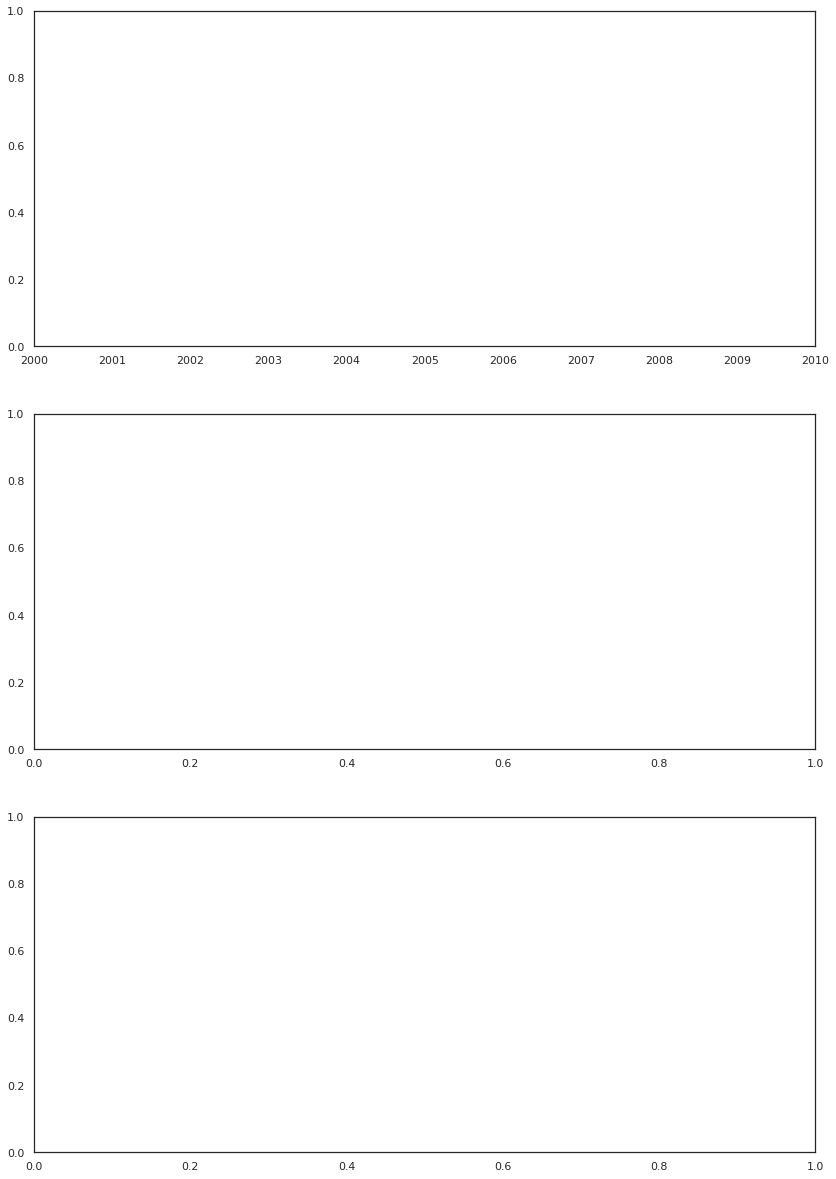

In [85]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})

a[0].scatter(dss.time, chlor_a, color='g', marker= ',', s = 1.0)
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (4., 21.), title='chlor with pressure')
a[2].set(ylim=(21., 4.), xlim = (t0, t1), title='pressure with time')

In [ ]:
do_precision = False

if do_precision:
    
    t0 = dt64('2019-06-01T00:00')
    t1 = dt64('2019-06-01T05:20')
    dss = ds.sel(time=slice(t0, t1))
    
else:
    t0 = dt64('2019-06-24T00:00')
    t1 = dt64('2019-06-28T00:00')
    day1 = '24'
    day2 = '27'              # will be 'day 27 inclusive' I think
    dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))

len(dss.time)

### Section on comparatives

Compares Oregon Slope Base 200m Platform... to Axial Base SP... to Oregon Slope Base SP... to Oregon Offshore SP 

In [50]:
# 
# Precision section works with precise times versus day-scale
#   The precise times are an experiment in using 2 hours 40 minutes to chop up the 9 profiles in the day in a regular manner...
#   but a better approach would be to detect the profiles and time-box each one individually. 
# 

do_precision = False

if do_precision:
    
    t0 = dt64('2019-06-01T00:00')
    t1 = dt64('2019-06-01T05:20')

    t0 = dt64('2019-06-01T02:40')
    t1 = dt64('2019-06-01T07:00')

    t0 = dt64('2019-06-01T05:20')
    t1 = dt64('2019-06-01T10:40')

    t0 = dt64('2019-06-01T07:00')
    t1 = dt64('2019-06-01T13:20')

    t0 = dt64('2019-06-01T10:40')
    t1 = dt64('2019-06-01T16:00')

    t0 = dt64('2019-06-01T10:40')
    t1 = dt64('2019-06-01T16:00')

    t0 = dt64('2019-06-01T10:40')
    t1 = dt64('2019-06-01T13:20')

    t0 = dt64('2019-06-01T00:00')
    t1 = dt64('2019-06-01T02:40')

    # t0 = dt64('2019-06-01')
    # t1 = dt64('2019-06-02')
    
    dss = ds.sel(time=slice(t0, t1))
    
else:
    t0 = dt64('2019-06-24T00:00')
    t1 = dt64('2019-06-28T00:00')

    day1 = '24'
    day2 = '27'              # will be 'day 27 inclusive' I think
    dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))

len(dss.time)

287911

[(0.0, 20.0), (737234.0, 737238.0), Text(0.5, 1.0, 'chlor with time')]

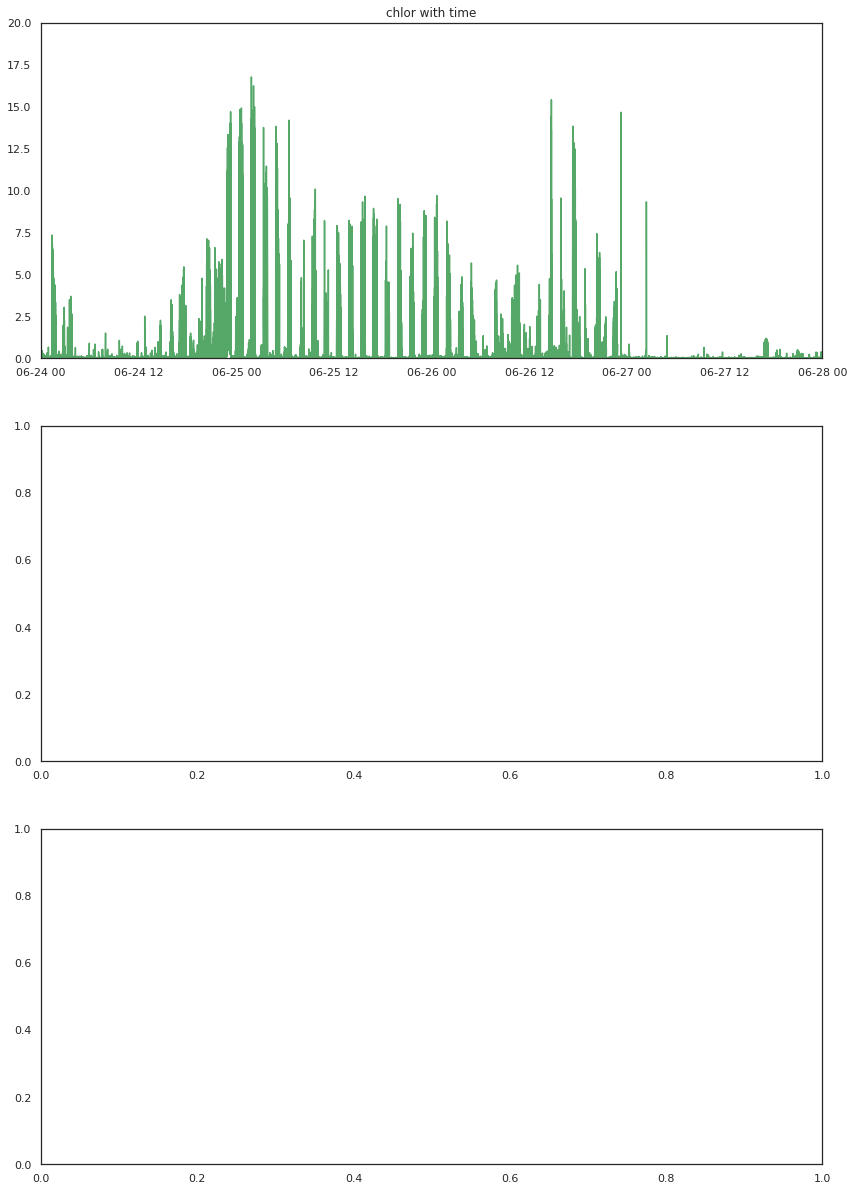

In [35]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
# pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
# a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
# a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 20.0), xlim = (t0, t1), title='chlor with time')
# a[1].set(ylim=(0., 1.), xlim = (0., 200.), title='chlor with pressure')
# a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

[(200.0, 0.0), (737234.0, 737238.0), Text(0.5, 1.0, 'pressure with time')]

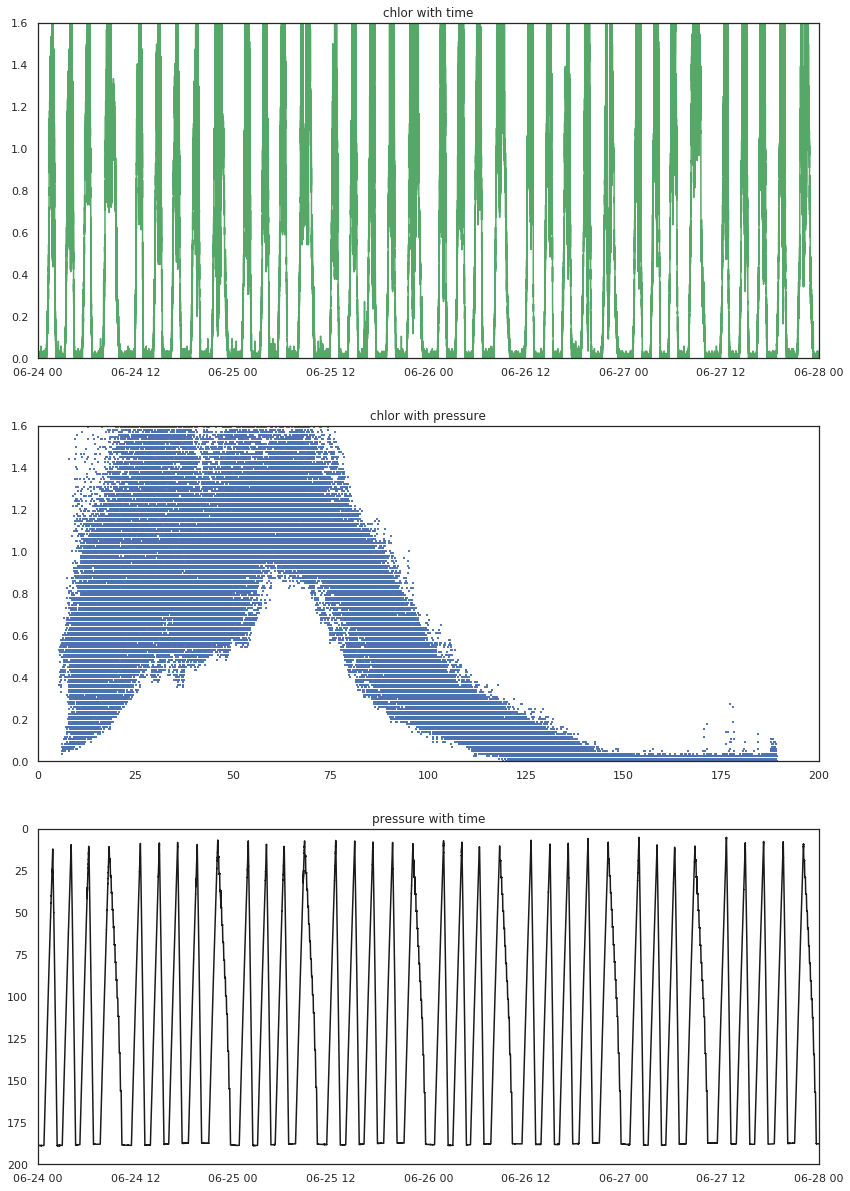

In [51]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (0., 200.), title='chlor with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

[(200.0, 0.0), (737234.0, 737238.0), Text(0.5, 1.0, 'pressure with time')]

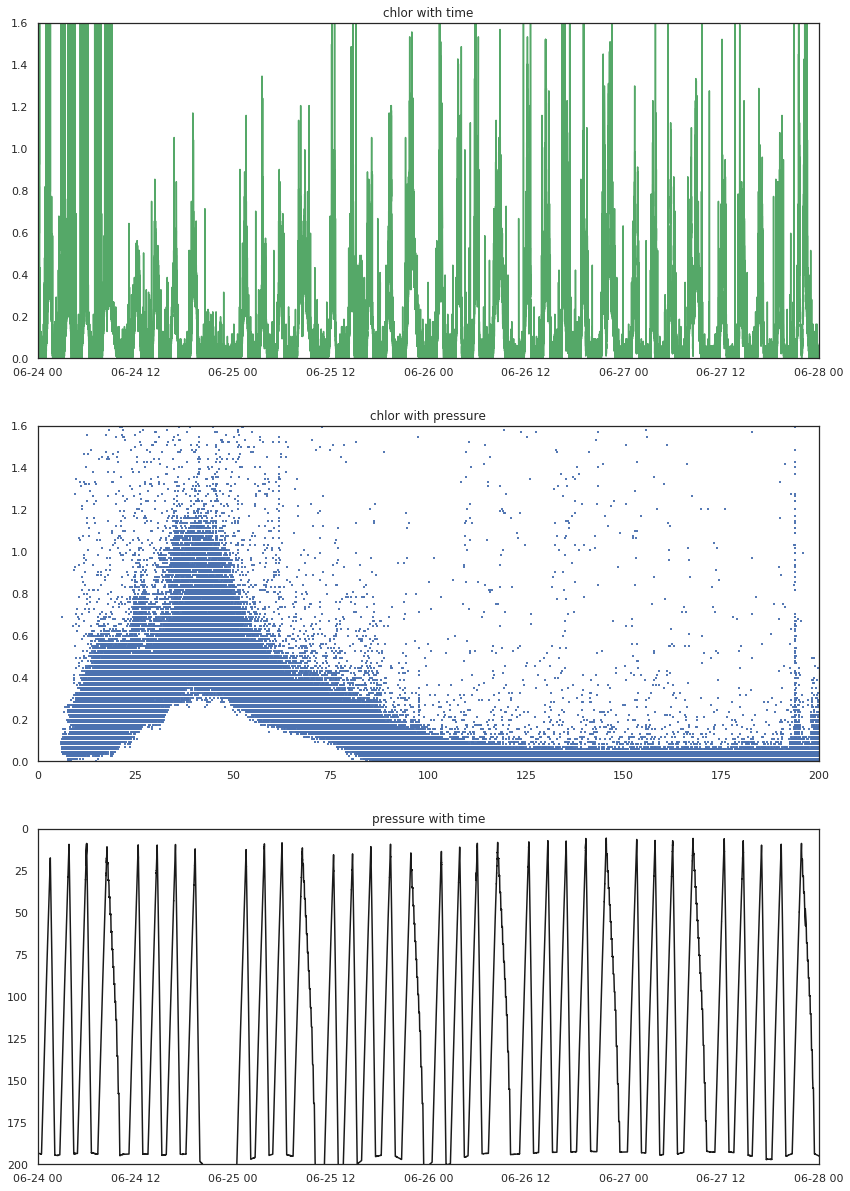

In [38]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (0., 200.), title='chlor with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

[(200.0, 0.0), (737234.0, 737238.0), Text(0.5, 1.0, 'pressure with time')]

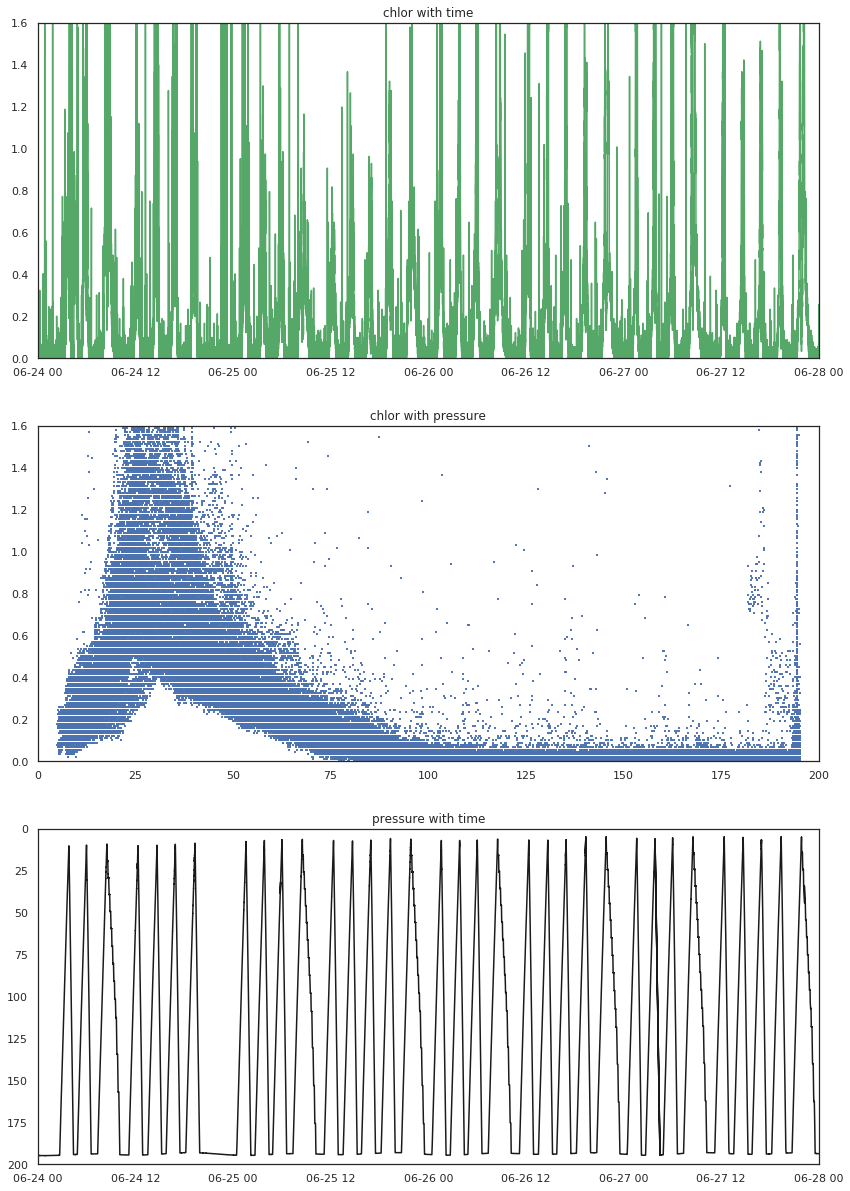

In [42]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a, color='g')
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
a[2].plot(dss.time, pressure, color='k') 

a[0].set(ylim=(0., 1.6), xlim = (t0, t1), title='chlor with time')
a[1].set(ylim=(0., 1.6), xlim = (0., 200.), title='chlor with pressure')
a[2].set(ylim=(200., 0.), xlim = (t0, t1), title='pressure with time')

### Resource code block


This is a 3 x 3 matrix of CTD and related-sensor time series charts from a `data_gallery` IPython notebook. 


```
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')
```

# Below This Mark Is Source Material Only

From work with Don November 13, 2019 on getting yodapy working properly; including skipping over to the original data source to pull NetCDF files...

In [ ]:
# Reprising an earlier cell let's go for CTD data (don't re-run this first line (kilroy) because that was done earlier)
ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
ooi.instruments                    # an attribute
ooi.data_availability()

In [ ]:
# This cell does not run by default because it generates a data retrieve
if False:
    begin_date = '2018-01-01'
    end_date = '2018-01-02'
    ooi.request_data(begin_date=begin_date, end_date=end_date)

In [ ]:
# Once the data order is complete we need a way of placing the URL in the ooi object so we do not have
#   to repeat the query. That goes into the yodapy README also. Are you tired of re-running this cell? 
#   Just run ooi.to_xarray() and it will do the polling for you. 
#
# This is also 'Falsed out'
if False: 
    ooi.check_status()

In [ ]:
# In the above cell ooi.check_status() can be re-run as a status check until the request is filled.
# If instead we use the .to_xarray() method the polling loop on the data request is automated. This 
#   could take some time; but when it works the end result is a list of Xarray Datasets. Why is this 
#   a list? Because the requested time range may produce results that are segmented in time, i.e. 
#   several Datasets. By returning them in sequence as a list we hope to recover everything available
#   in a time-contiguous fashion (subject to data dropouts if there are any).
if False: 
    ds = ooi.to_xarray()
    ds[0]

In [ ]:
# Saving (say the first in the list) Dataset to a NetCDF file via .to_netcdf() will not work because 
# OOI data are not CF-compliant in format
# ds[0].to_netcdf('fubar.nc')

# This will reach into the OOI system (not the CAVA system) and download and save NetCDF content
if False:
    filenamelist = ooi.download_netcdfs()
    print(len(filenamelist))

In [ ]:
import xarray as xr

In [ ]:
if False: 
    ooids = xr.open_dataset(filenamelist[0])  
    ooids

# better: use open_mfdataset(filenamelist) to concatenate a segmented result
# caveat: don't use against hetero instrument results as these will not stack properly in a Dataset

In [ ]:
# Start over: search specific to chlorophyll via fluorometers. Notice the instruments value is a search term
ooi.search(region='cabled', instrument='fluorometer')
ooi.instruments                    # an attribute
ooi.data_availability()

# to reset the filters use ooi.clear() to avoid sub-filtering filtered results to arrive at nothing!

# The following table lists possible instruments as *column headers*. This is subsequently 
#   transposed in the data availability graph: rows for each instrument's time series. 

# big warning

In the foregoing we got 12 fluorometer hits. These do not include "Oregon Offshore" which is the distal node
of the Endeavor array that sits on the RCA for power and data. This means that it is necessary to go back and
re-do the query to pick up Oregon Offshore.

In [ ]:
# Let's be specific to the Oregon Slope Base profiler
ooi.search(region='cabled', site = 'Oregon Slope Base', node = 'Shallow Profiler', instrument='fluorometer', )
ooi.instruments                    # an attribute
ooi.data_availability()

In [ ]:
if False: 
    begin_date = '2019-06-01'
    end_date = '2019-09-30'
    ooi.request_data(begin_date=begin_date, end_date=end_date, time_check = False)

In [ ]:
if False:
    chlords = ooi.to_xarray()

In [ ]:
if False: 
    filenamelist = ooi.download_netcdfs()

In [ ]:
chlor = xr.open_mfdataset(filenamelist)
chlor

In [ ]:
# how many results came back? Remember OOI might chop up the data into contiguous time segments arbitrarily
len(filenamelist)

In [ ]:
chlor = chlor.swap_dims({'obs':'time'})
chlor.fluorometric_chlorophyll_a.plot()

In [ ]:
# Looking ahead; we need zarr...
# !pip install zarr

In [ ]:
# If this cell fails because you need zarr and it is not installed: See previous cell
# Looking ahead to zarr
import s3fs

cavapath = 'io2data-test/data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record'
FS = s3fs.S3FileSystem(anon=True)        # because not using an AWS cred
s3ds = xr.open_zarr(store=s3fs.S3Map(cavapath, s3=FS), consolidated=True)


In [ ]:
s3ds

In [ ]:
zarrchlor=s3ds.sel(time=slice('2019-06-01', '2019-09-30'))
zarrchlor

In [ ]:
zarrchlor.fluorometric_chlorophyll_a.plot()

In [ ]:
from dask.diagnostics import ProgressBar

In [ ]:
with ProgressBar():
    zarrchlor.plot.scatter(x='time', y='int_ctd_pressure', hue='fluorometric_chlorophyll_a')

In [ ]:
ooi.sites

In [ ]:
ooi.search(region='Coastal Endurance')
ooi.instruments

In [ ]:
ooi.search(region='endurance', instrument='fluorometer')
ooi.instruments                    # an attribute
ooi.data_availability()